# k-Nearest Neighbor Classification

## 1. Read the Iris dataset

In [4]:
import pandas as pd
iris = pd.read_csv('Iris.csv', header = None)
# Create column labels
iris.columns = ['Sepal Length', 'Sepal Width', 'Petal Length', 'Petal Width', 'Species']

## 2. Classify the training set
### 2.1. Try different sets of features

In [8]:
from sklearn.neighbors import KNeighborsClassifier

# Define all possible sets of features
featureSets = [[0,1], [0,2], [0,3], [1,2], [1,3], [2,3],
               [0,1,2], [0,1,3], [0,2,3], [1,2,3],
               [0,1,2,3]]

# Run through all sets of features
for features in featureSets:
    # Assemble the training set 
    X = iris.iloc[:, features].values
    y = pd.factorize(iris['Species'].values)[0]
    # Training and training accuracy
    print("Features:", features, end = "\t")
    model = KNeighborsClassifier()
    model.fit(X, y)
    accuracy = model.score(X, y)
    print("Accuracy:", accuracy)

Features: [0, 1]	Accuracy: 0.8333333333333334
Features: [0, 2]	Accuracy: 0.9666666666666667
Features: [0, 3]	Accuracy: 0.9666666666666667
Features: [1, 2]	Accuracy: 0.96
Features: [1, 3]	Accuracy: 0.96
Features: [2, 3]	Accuracy: 0.96
Features: [0, 1, 2]	Accuracy: 0.96
Features: [0, 1, 3]	Accuracy: 0.9666666666666667
Features: [0, 2, 3]	Accuracy: 0.9733333333333334
Features: [1, 2, 3]	Accuracy: 0.9666666666666667
Features: [0, 1, 2, 3]	Accuracy: 0.9666666666666667


### 2.2. Confusion matrix

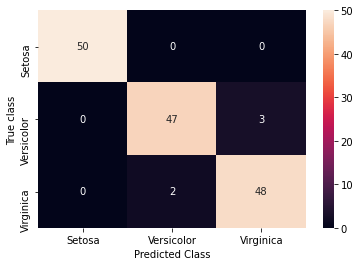

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Generate the training set
features = [0,1,2,3]
X = iris.iloc[:,features].values
y = pd.factorize(iris['Species'].values)[0]

# Train the model and predict the class for each training set
model = KNeighborsClassifier()
model.fit(X, y)
y_pred = model.predict(X)

# Calculate the confusion matrix
confusion = confusion_matrix(y, y_pred)

# Plot the confusion matrix as a heat map
def visualize_confusion_matrix(confusion):
    categories = ['Setosa', 'Versicolor', 'Virginica']
    sns.heatmap(confusion, annot = True, xticklabels = categories, yticklabels = categories)
    plt.xlabel("Predicted Class")
    plt.ylabel("True class")
    plt.show()
    
visualize_confusion_matrix(confusion)

### 2.3. Classification regions

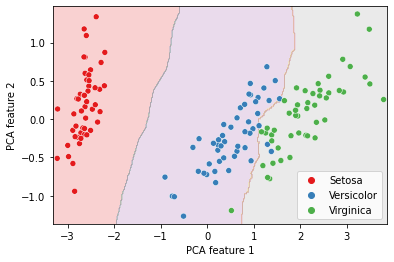

In [11]:
import numpy as np
from sklearn.decomposition import PCA as sklearnPCA

# Plot the decision boundaries
# If the number of features is more than 2, reduce dimensionality to 2
if len(features) > 2:
    pca = sklearnPCA(n_components = 2)
    pca.fit(X)
    X_pca = pca.transform(X)
else: 
    X_pca = X
# Determine the limits of the space
xMin, xMax = X_pca[:, 0].min() - 0.1, X_pca[:, 0].max() + 0.1
yMin, yMax = X_pca[:, 1].min() - 0.1, X_pca[:, 1].max() + 0.1
# Generate the 2D mesh for the decision surface
resolution = 0.02
xx, yy = np.meshgrid(np.arange(xMin, xMax, resolution), np.arange(yMin, yMax, resolution))
meshPts = np.array([xx.ravel(), yy.ravel()]).T
# Transform the mesh points back to the original space
if len(features) > 2:
    meshPts = pca.inverse_transform(meshPts)
# Predict the classification for the mesh points
predictedMesh = model.predict(meshPts)
predictedMesh = predictedMesh.reshape(xx.shape)
# Set up the figure
fig, ax =  plt.subplots(1,1)
# Plot the regions and decision boundaries using the mesh
plt.contourf(xx, yy, predictedMesh, alpha = 0.2, cmap = 'Set1')
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
# Plot each category
sns.scatterplot(x = X_pca[:,0], y = X_pca[:,1], hue = y, palette = 'Set1')
# Add axis labels 
if len(features) > 2:
    plt.xlabel("PCA feature 1")
    plt.ylabel("PCA feature 2")
else:
    plt.xlabel(iris.columns[features[0]])
    plt.ylabel(iris.columns[features[1]])
# Customize legend labels
handles, labels = ax.get_legend_handles_labels()
categories = ['Setosa', 'Versicolor', 'Virginica']
plt.legend(handles, categories)
plt.show()

## 3. Overfitting and underfitting

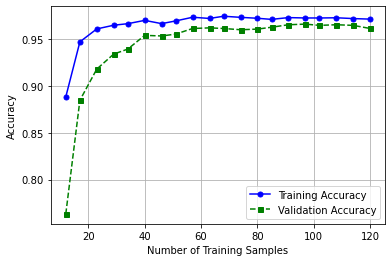

In [13]:
from sklearn.model_selection import learning_curve
from sklearn.model_selection import StratifiedShuffleSplit

# Generate the training set
features = [0,1,2,3]
X = iris.iloc[:,features].values
y = pd.factorize(iris['Species'].values)[0]

# Create the model
model = KNeighborsClassifier()

# Test different training sizes
train_sizes = np.linspace(0.1, 1.0, 20)

# Create the cross validation objects
# Specify a large number of splits to average different trials and obtain a smoother curve
cv = StratifiedShuffleSplit(n_splits=50, test_size = 0.2, random_state=1)

# Generate the learning curves averages
train_sizes, train_scores, test_scores = learning_curve(model, X, y, train_sizes = train_sizes, cv = cv)
train_mean = np.mean(train_scores, axis = 1)
test_mean = np.mean(test_scores, axis = 1)

# Plot the learning curves
plt.plot(train_sizes, train_mean, color = 'blue', marker = 'o', markersize = 5, label = 'Training Accuracy')
plt.plot(train_sizes, test_mean, color = 'green', marker = 's', linestyle = '--', markersize = 5, label = 'Validation Accuracy')
plt.grid()
plt.xlabel('Number of Training Samples')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

## 4. Parameter setting
### 4.1. Validation curves

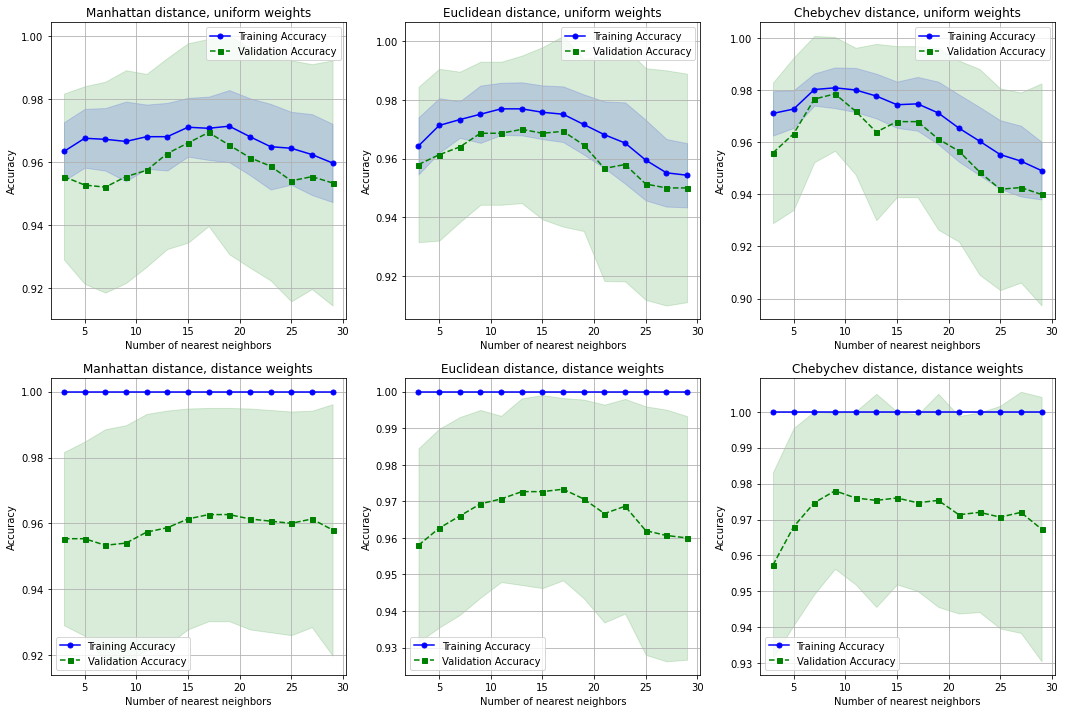

In [39]:
from sklearn.model_selection import validation_curve

# Generate the training set
features = [0,1,2,3]
X = iris.iloc[:,features].values
y = pd.factorize(iris['Species'].values)[0]

# Explore a range values for the number of neighbors
param_range = range(3,30,2)

''' Generate and plot validation curves '''
def generate_and_plot_validation_curves(model, ax):
    cv = StratifiedShuffleSplit(n_splits=50, test_size = 0.2, random_state=1)
    # Generate the validation curves averages and standard deviations 
    train_scores, test_scores = validation_curve(model, X, y, param_name = 'n_neighbors', param_range = param_range, cv = cv)
    train_mean = np.mean(train_scores, axis = 1)
    train_std = np.std(train_scores, axis = 1)
    test_mean = np.mean(test_scores, axis = 1)
    test_std = np.std(test_scores, axis = 1)

    # Plot the validation curves in the figure axis
    ax.plot(param_range, train_mean, color = 'blue', marker = 'o', markersize = 5, label = 'Training Accuracy')
    ax.fill_between(param_range, train_mean + train_std, train_mean - train_std, alpha = 0.15, color = 'blue')
    ax.plot(param_range, test_mean, color = 'green', marker = 's', linestyle = '--', markersize = 5, label = 'Validation Accuracy')
    ax.fill_between(param_range, test_mean + test_std, test_mean - test_std, alpha = 0.15, color = 'green')
    ax.grid()
    ax.set_xlabel('Number of nearest neighbors')
    ax.set_ylabel('Accuracy')
    ax.legend()

# Generate the validation curves for a model using the Manhattan distance and uniform weights
fig, ax = plt.subplots(2, 3, figsize = (18,12))
model = KNeighborsClassifier(p = 1)
generate_and_plot_validation_curves(model, ax[0][0])
ax[0][0].set_title('Manhattan distance, uniform weights')

# Generate the validation curves for a model using the Euclidean distance and uniform weights
model = KNeighborsClassifier(p = 2)
generate_and_plot_validation_curves(model, ax[0][1])
ax[0][1].set_title('Euclidean distance, uniform weights')

# Generate the validation curves for a model using the Chebychev distance and uniform weights
model = KNeighborsClassifier(p = 10)
generate_and_plot_validation_curves(model, ax[0][2])
ax[0][2].set_title('Chebychev distance, uniform weights')

# Generate the validation curves for a model using the Manhattan distance and distance weights
model = KNeighborsClassifier(p = 1, weights = 'distance')
generate_and_plot_validation_curves(model, ax[1][0])
ax[1][0].set_title('Manhattan distance, distance weights')

# Generate the validation curves for a model using the Euclidean distance and distance weights
model = KNeighborsClassifier(p = 2, weights = 'distance')
generate_and_plot_validation_curves(model, ax[1][1])
ax[1][1].set_title('Euclidean distance, distance weights')

# Generate the validation curves for a model using the Chebychev distance and distance weights
model = KNeighborsClassifier(p = 10, weights = 'distance')
generate_and_plot_validation_curves(model, ax[1][2])
ax[1][2].set_title('Chebychev distance, distance weights')

plt.show()

### 4.2. Nested cross validation and grid search

F1 Score: 0.9598997493734336 +/- 0.03274171753093638


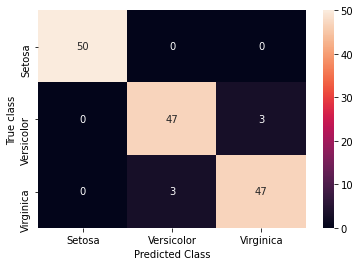

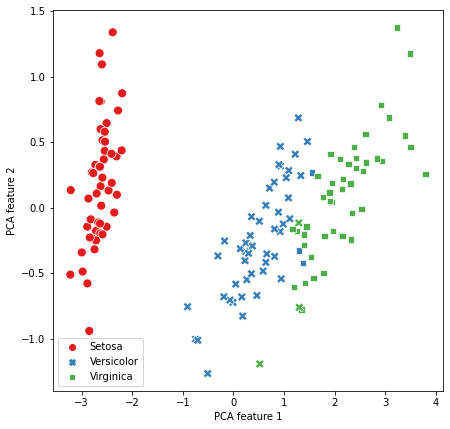

In [24]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict

# Generate the training set
features = [0,1,2,3]
X = iris.iloc[:,features].values
y = pd.factorize(iris['Species'].values)[0]

# Create the model
model = KNeighborsClassifier()

# Set up the grid of parameters and the grid search
hyperParams = {'n_neighbors': range(3, 30, 2),
               'weights': ['uniform', 'distance'],
               'p' : [1, 2, 5, 10, 50]}
search = GridSearchCV(model, hyperParams, cv = 2, scoring = 'f1_macro')

# Perform the cross validation
scores = cross_val_score(search, X, y, scoring = 'f1_macro', cv = 5)
print('F1 Score:', np.mean(scores), '+/-', np.std(scores))

# Show the confusion matrix
y_pred = cross_val_predict(search, X, y, cv = 5)
conf = confusion_matrix(y, y_pred)
visualize_confusion_matrix(conf)

# Show the classification plot
def visualize_classification(X, y, y_pred):
    fig, ax = plt.subplots(1, 1, figsize = (7,7))
    # If the number of features is more than 2, use the PCA components for plotting
    if len(features) > 2:
        xAxis = X_pca[:,0]
        yAxis = X_pca[:,1]
    else:
        xAxis = X[:,features[0]]
        yAxis = X[:,features[1]]
    # Scatter plot of the data
    # Points color is the true class
    # Points marker is the predicted class
    sns.scatterplot(x = xAxis, y = yAxis, hue = y, style = y_pred, s = 80, palette = 'Set1')
    # Add axis labels 
    if len(features) > 2:
        plt.xlabel("PCA feature 1")
        plt.ylabel("PCA feature 2")
    else:
        plt.xlabel(iris.columns[features[0]])
        plt.ylabel(iris.columns[features[1]])
    # Customize legend labels
    handles, labels = ax.get_legend_handles_labels()
    plt.legend(handles, categories)
    plt.show()
    
visualize_classification(X, y, y_pred)

### 4.3. Best parameters

In [30]:
from sklearn.model_selection import train_test_split

# Create the model
model = KNeighborsClassifier()

# Set up the grid of parameters and the grid search
hyperParams = {'n_neighbors': range(3, 30, 2),
               'weights': ['uniform', 'distance'],
               'p' : [1, 2, 5, 10, 50]}
search = GridSearchCV(model, hyperParams, cv = 5, scoring = 'f1_macro')

# Generate random training and test sets
# Create the iris categories so that the conversion from a category to a number is always the same across different splits
irisCategories = pd.factorize(iris['Species'].values)[0]
X_train, X_test, y_train, y_test = train_test_split(iris, irisCategories, test_size = 0.2, shuffle = True, stratify = iris['Species'])

# Train the model using the training set 
#search.fit(X_train.iloc[:,features], y_train)
search.fit(iris.iloc[:,features], irisCategories)

# Look at scores
results = pd.DataFrame.from_dict(search.cv_results_)
print("Best score:", search.best_score_)
print("Best parameters:", search.best_params_)
results

Best score: 0.9866332497911445
Best parameters: {'n_neighbors': 9, 'p': 5, 'weights': 'uniform'}


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_neighbors,param_p,param_weights,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.002487,0.000792,0.003580,0.000949,3,1,uniform,"{'n_neighbors': 3, 'p': 1, 'weights': 'uniform'}",0.966583,0.966583,0.932660,0.933333,1.0,0.959832,0.025080,112
1,0.001600,0.000488,0.002411,0.000482,3,1,distance,"{'n_neighbors': 3, 'p': 1, 'weights': 'distance'}",0.966583,0.966583,0.932660,0.933333,1.0,0.959832,0.025080,112
2,0.001201,0.000397,0.002801,0.000399,3,2,uniform,"{'n_neighbors': 3, 'p': 2, 'weights': 'uniform'}",0.966583,0.966583,0.932660,0.966583,1.0,0.966482,0.021295,86
3,0.001990,0.000018,0.001811,0.000405,3,2,distance,"{'n_neighbors': 3, 'p': 2, 'weights': 'distance'}",0.966583,0.966583,0.932660,0.966583,1.0,0.966482,0.021295,86
4,0.001804,0.000405,0.002996,0.000616,3,5,uniform,"{'n_neighbors': 3, 'p': 5, 'weights': 'uniform'}",0.966583,0.966583,0.932660,0.966583,1.0,0.966482,0.021295,86
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
135,0.002002,0.000003,0.002397,0.000490,29,5,distance,"{'n_neighbors': 29, 'p': 5, 'weights': 'distan...",0.933333,1.000000,0.899749,0.966583,1.0,0.959933,0.038948,102
136,0.001409,0.000485,0.002799,0.000401,29,10,uniform,"{'n_neighbors': 29, 'p': 10, 'weights': 'unifo...",0.899749,1.000000,0.899749,0.933333,1.0,0.946566,0.045319,134
137,0.001500,0.000437,0.002621,0.000488,29,10,distance,"{'n_neighbors': 29, 'p': 10, 'weights': 'dista...",0.933333,1.000000,0.899749,0.966583,1.0,0.959933,0.038948,102
138,0.001799,0.000400,0.002594,0.000482,29,50,uniform,"{'n_neighbors': 29, 'p': 50, 'weights': 'unifo...",0.899749,1.000000,0.899749,0.933333,1.0,0.946566,0.045319,134


## 5. Cross validation
### 5.1. Accuracy

In [35]:
from sklearn.model_selection import cross_val_score

# Generate the training set
features = [0,1,2,3]
X = iris.iloc[:,features].values
y = pd.factorize(iris['Species'].values)[0]

# Create the model
model = KNeighborsClassifier(n_neighbors = 9, p = 5)

# Stratified cross validation is used, cv specifies the number of folds
cross_val_score(model, X, y, cv = 5, scoring = "accuracy")

array([0.96666667, 1.        , 1.        , 0.96666667, 1.        ])

### 5.2. Confusion matrix

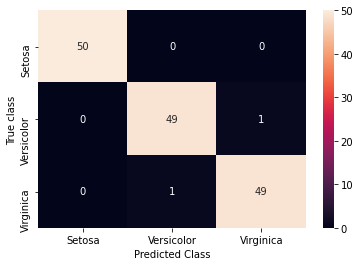

In [36]:
# First predict the classification for each sample using cross validation
from sklearn.model_selection import cross_val_predict
# Stratified cross validation is used, cv specifies the number of folds
y_pred = cross_val_predict(model, X, y, cv = 5)

# Compare the expected class and the predicted class
from sklearn.metrics import confusion_matrix
conf = confusion_matrix(y, y_pred)

# Plot the confusion matrix as a heat map
visualize_confusion_matrix(conf)

### 5.3. Precision, recall, and f1 score

In [37]:
# Calculate the prediction, recall, and f1 score using expected class and predicted class
from sklearn.metrics import precision_score, recall_score, f1_score

# This is not a binary classification, so we need to decide how to calculate TP, FP, TN, and FN
# micro: Calculate metrics globally by counting the total true positives, false negatives and false positives
# macro: Calculate metrics for each label, and find their unweighted mean which does not take label imbalance into account
combine_criterion = "macro"
precision = precision_score(y, y_pred, average = combine_criterion)
recall = recall_score(y, y_pred, average = combine_criterion)
f1 = f1_score(y, y_pred, average = combine_criterion)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

Precision: 0.9866666666666667
Recall: 0.9866666666666667
F1 Score: 0.9866666666666667


### 5.4. Visualization

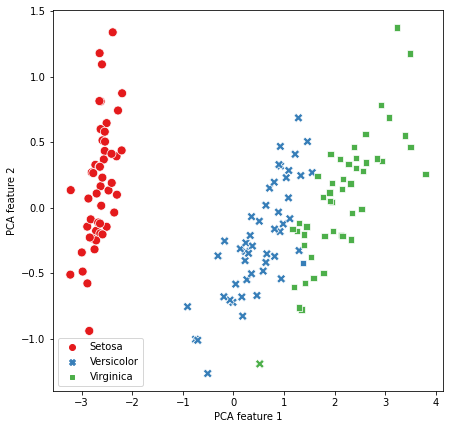

In [38]:
visualize_classification(X, y, y_pred)